**Matrix Computations** project (load part) \
*Lossy image compression using Singular Value Decompostion and Fast Fourier Transform*
## Nima Kelidari - 98108124 ##
**Matrix Computations course - Dr. razvan**

**Step0:** Import essential libraries

In [666]:
import zipfile
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 


In [667]:
from Essentials import show_magnitude,clipping
from Fourier import fourier_transform,inverse_fourier,fourier_uv_sharpening
from Filters import lowpass,highpass

**Step1:** Define values

In [668]:
#name = input('import file name')
name = 'pepper'

In [669]:
k = (10 ** -6) * 9
component = []
channels = []
con_type = 0
scale = 0
lowpass_coef = 75
highpass_coef = 21

**Step2:** Unzip the file

In [670]:
with zipfile.ZipFile(f'{name}.zip', 'r') as zip_ref:
    zip_ref.extractall(name)

**Step3:** Define load function

In [671]:
def load(name):
    ch1,ch2,ch3,con_type,scale =  np.load(f'{name}/config.npy')
    channels = [ch1,ch2,ch3]
    con_type = con_type.astype('float')
    scale = scale.astype('float')
    def load_channel(color):
        im_u = cv2.imread(f'{name}/u_{color}.png', -1)
        im_v = cv2.imread(f'{name}/v_{color}.png', -1)
        
        ss = np.load(f'{name}/s_{color}.npy')
        mu , mv , th = np.load(f'{name}/max_{color}.npy')
        component.append(int(th))
        im_u = np.array(im_u,dtype = float)
        im_v = np.array(im_v,dtype = float)
        uu = ((im_u-con_type)/con_type) * mu
        vv = ((im_v-con_type)/con_type) * mv

        return ( uu @ np.diag(ss) @ vv)

    b = np.array(np.clip(np.round(load_channel(channels[0])),0,255),dtype='int')
    g = np.array(np.clip(np.round(load_channel(channels[1])),0,255),dtype='int')
    r = np.array(np.clip(np.round(load_channel(channels[2])),0,255),dtype='int')

    return b,g,r,scale

**Step4:** Run function and convert it to an image

In [672]:
b_f,g_f,r_f,scale = load(name)

image1 = cv2.cvtColor(np.stack((b_f,g_f,r_f),axis = 2).astype('uint8'),cv2.COLOR_BGR2GRAY)

**Step5:** Apply fourier transform and pass them throw highpass and lowpass filters

(<AxesSubplot:title={'center':'lowpass gaussian kernel'}>,
 Text(0.5, 1.0, 'lowpass gaussian kernel'))

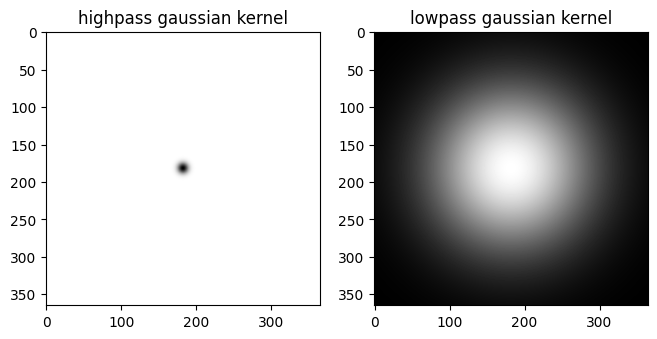

In [673]:
b,g,r = fourier_transform(b_f[:-1,:-1]),fourier_transform(g_f[:-1,:-1]),fourier_transform(r_f[:-1,:-1])
#b,g,r = fourier_transform(b_f),fourier_transform(g_f),fourier_transform(r_f)

lowpass_filter,filter_l = lowpass(lowpass_coef, image1.astype('int'))
b_l, g_l, r_l = np.multiply(b, lowpass_filter), np.multiply(g, lowpass_filter), np.multiply(r, lowpass_filter)

highpass_filter,filter_h = highpass(highpass_coef, image1.astype('int'))
b_h, g_h, r_h = np.multiply(b, highpass_filter), np.multiply(g, highpass_filter), np.multiply(r, highpass_filter)

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1),plt.imshow(filter_h, cmap='gray'), plt.title(f'highpass gaussian kernel')
plt.subplot(2, 3, 2),plt.imshow(filter_l, cmap='gray'), plt.title(f'lowpass gaussian kernel')

(<AxesSubplot:title={'center':'original'}>,
 Text(0.5, 1.0, 'original'))

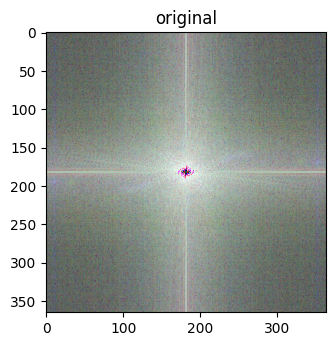

In [674]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 3), plt.imshow(cv2.cvtColor(cv2.merge((mag)),cv2.COLOR_BGR2RGB), cmap='gray'), plt.title(f'original')

**Step6:** Show results of the filters

(<AxesSubplot:title={'center':'lowpass'}>,
 Text(0.5, 1.0, 'lowpass'))

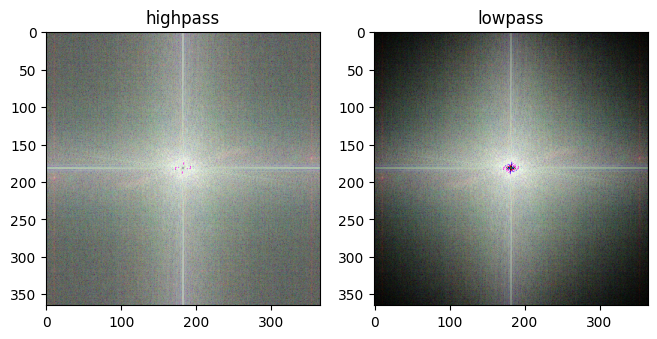

In [675]:
mag_l = show_magnitude(b_l, 20),show_magnitude(g_l, 20),show_magnitude(r_l, 20)
mag_h = show_magnitude(b_h, 20),show_magnitude(g_h, 20),show_magnitude(r_h, 20)
mag = show_magnitude(b, 20),show_magnitude(g, 20),show_magnitude(r, 20)
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1),plt.imshow(cv2.merge((mag_h)), cmap='gray'), plt.title(f'highpass')
plt.subplot(2, 3, 2), plt.imshow(cv2.merge((mag_l)), cmap='gray'), plt.title(f'lowpass')
# plt.subplot(2, 3, 3), plt.imshow(cv2.cvtColor(cv2.merge((mag)),cv2.COLOR_BGR2RGB), cmap='gray'), plt.title(f'original')

**Step7:** Sharp lowpass image for more details

(<AxesSubplot:title={'center':'reduced_uv_fourier'}>,
 Text(0.5, 1.0, 'reduced_uv_fourier'))

<Figure size 1200x600 with 0 Axes>

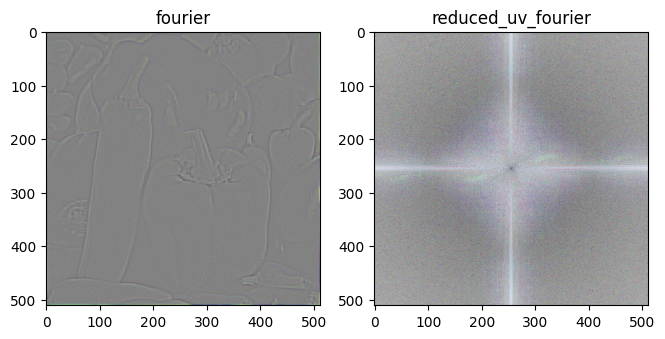

In [676]:
l = cv2.merge((inverse_fourier(b_l), inverse_fourier(g_l), inverse_fourier(r_l))).astype('uint8')
h = cv2.merge((inverse_fourier(b_h), inverse_fourier(g_h), inverse_fourier(r_h))).astype('uint8')
without_fourier_image = cv2.merge((inverse_fourier(b), inverse_fourier(g), inverse_fourier(r))).astype('uint8')

plt.figure(figsize=(12, 6))

l_final = cv2.resize(l, (0,0), fx=scale, fy=scale) 
h_final = cv2.resize(h, (0,0), fx=scale, fy=scale) 
without_fourier_image_final = cv2.resize(without_fourier_image, (0,0), fx=scale, fy=scale) 

final , fourier_image , reduced_uv_fourier = fourier_uv_sharpening(l_final.astype('int'),k)
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1),plt.imshow(fourier_image.astype('uint8'), cmap='gray'), plt.title(f'fourier')
plt.subplot(2, 3, 2),plt.imshow(reduced_uv_fourier.astype('uint8'), cmap='gray'), plt.title(f'reduced_uv_fourier')

**Step8:** Add highpass image to result image for edge details

In [677]:
h_final[h_final < 50] = 0
result = final.astype('int') + h_final*0.8
result = clipping(result).astype('uint8')

**Step9:** Present results

(<AxesSubplot:title={'center':'Without furier image'}>,
 Text(0.5, 1.0, 'Without furier image'))

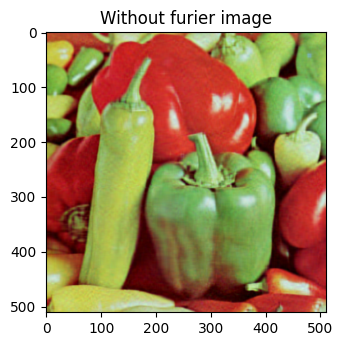

In [678]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 4),plt.imshow(cv2.cvtColor(without_fourier_image_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Without furier image')


(<AxesSubplot:title={'center':'lowpass image'}>,
 Text(0.5, 1.0, 'lowpass image'))

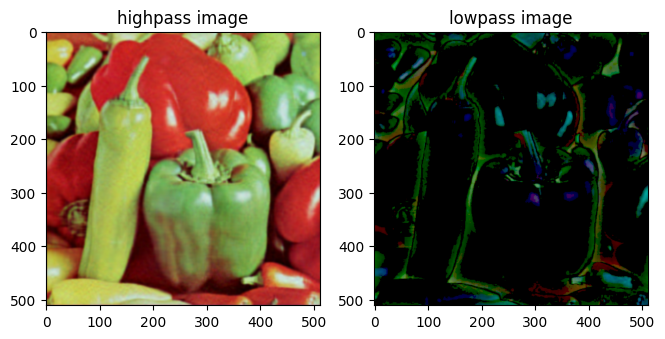

In [679]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 3, 1),plt.imshow(cv2.cvtColor(l_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title(f'highpass image')

plt.subplot(2, 3, 2),plt.imshow(cv2.cvtColor(h_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title(f'lowpass image')

(<AxesSubplot:title={'center':'Result image'}>,
 Text(0.5, 1.0, 'Result image'))

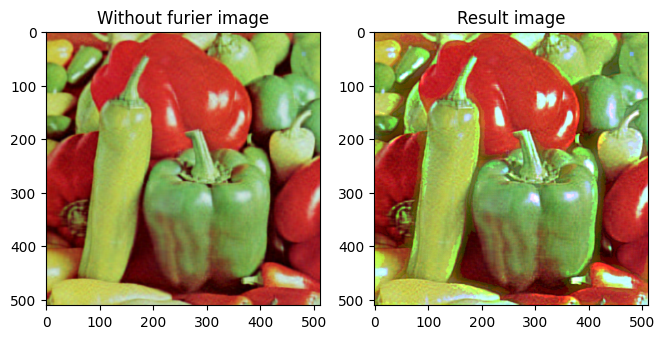

In [680]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 3, 1),plt.imshow(cv2.cvtColor(without_fourier_image_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Without furier image')

plt.subplot(2, 3, 2),plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Result image')

(<AxesSubplot:title={'center':'Result image'}>,
 Text(0.5, 1.0, 'Result image'))

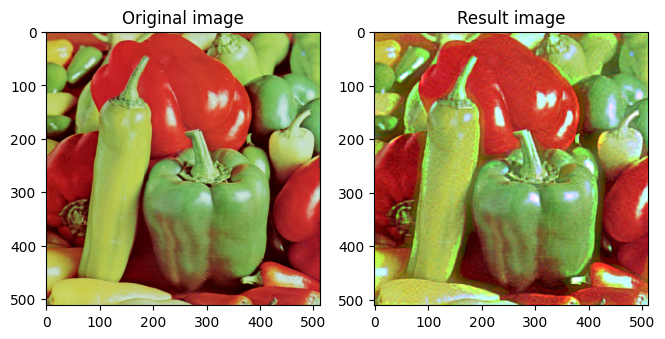

In [681]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 3, 1),plt.imshow(cv2.cvtColor(cv2.imread(f"{name}.png",1),cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Original image')
plt.subplot(2, 3, 2),plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Result image')

(<AxesSubplot:title={'center':'Result image'}>,
 Text(0.5, 1.0, 'Result image'))

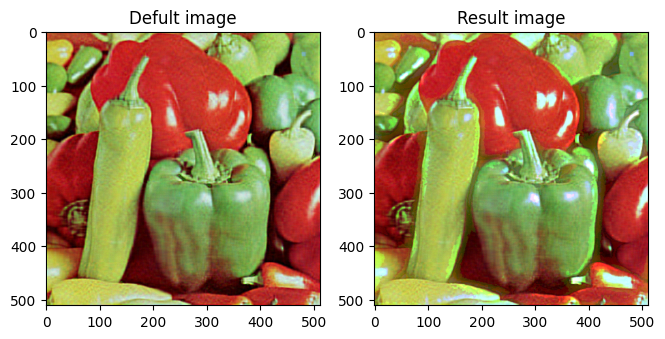

In [682]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 3, 1),plt.imshow(cv2.cvtColor(final_fix,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Defult image')
plt.subplot(2, 3, 2),plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Result image')

True

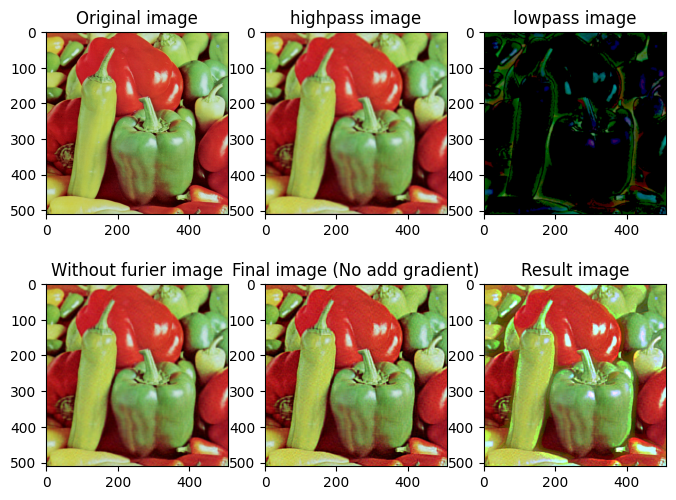

In [683]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 3, 1),plt.imshow(cv2.cvtColor(cv2.imread(f"{name}.png",1),cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Original image')

plt.subplot(2, 3, 2),plt.imshow(cv2.cvtColor(l_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title(f'highpass image')

plt.subplot(2, 3, 3),plt.imshow(cv2.cvtColor(h_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title(f'lowpass image')

plt.subplot(2, 3, 4),plt.imshow(cv2.cvtColor(without_fourier_image_final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Without furier image')

plt.subplot(2, 3, 5),plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Final image (No add gradient)')

plt.subplot(2, 3, 6),plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Result image')

cv2.imwrite("result.jpg",result)


In [684]:
#final_fix = result.copy()